In [1]:

import os 
import pickle 
import evaluate_predictions # this file is copied from https://github.com/informagi/REL/pull/151. Use this file later when PR merged
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import re
import warnings

# update the parameters here 
path_data = "output_data/"
path_efficiencytest = f"{path_data}efficiency_test/"
path_profiling = f"{path_efficiencytest}profile/"
path_msmarco = f"{path_data}msmarco/"

def filter_df(df, keep_strings, src):
    "Filter a dataframe with timings by function. Keep timings for functions with keep_strings."
    df = df.loc[df["fn"].str.contains(keep_strings), :].copy()
    df = df.loc[df['fn'] != "predict"] # predict calls with_coref, get_data_items, __predict
    df['src'] = src
    return df 


Set some more parameters

In [2]:
coref_options = {
    "_all": "all",
    "_lsh": "lsh",
    "_off": "off"
}
name_aida_dataset = "aida_testB"



### Analysing efficiency and effectiveness
- Questions to be answered
    - Does `with_coref` impact the efficiency and effectiveness of REL? 
    - Given the time complexity of `with_coref`, does `with_coref` impact the efficiency differently for documents with more vs fewer mentions?
- Efficiency: large overhead from `__predict`,  the quadratic time complexity of `with_coref` starts to dominate the overal running time of entity disambiguation only for documents with 4000 mentions or more. This holds for both of the following two data sets:
    - AIDA; use the msmarco data (tagged mentions from Chris) instead
- Effectiveness
    1. AIDA: Compare aggregate precision and recall when using `with_coref` and when not 
        - similar results independently of whether `with_coref` is used 
    2. AIDA: Compare precision and recall only for mentions that are coreferences
        - Find coreference mentions in the gold entities
        - Subset detected mentions to only coreferences 
        - *Result 1--comparing the coreference sample to the full sample of mentions*: REL performs worse at detecting mentions that are coreferences than mentions that are not. This is particularly the case for recall, which only 40 percent for coreferring mentions. The main reason for this is low recall in the mention detection part. A quick inspection indicates that many coreferences that use only last names are missed ("arafat" for "yasser arafat"). 
        - *Result 2--comparing within coreference sample when using `with_coref` and not*: precision and recall are lower when not using `with_coref` (2ppt and <1ppt, respectively)
    3. msmarco: no ground truth. For tagged mentions, compare predicted entities when using `with_coref` and when not using it. 
        - 60 percent of coreferring mentions are linked to a different entity when using `with_coref` versus when not using it. 
        - The results perhaps suggest that this difference gets larger with more mentions, but we do not have enough large documents to test this directly


# 1. AIDA data 
## 1.1. Effectiveness: ED aggregate predictions with/without coref, across data sets 

Terminology
- 50 and 500 refer to the maximum number of documents from AIDA kept
- full sample refers to all detected mentions in a document. restricted sample refers to only mentions in a document that are identified as coreferences.

In [3]:
files = os.listdir(f"{path_efficiencytest}/predictions")
files = [f for f in files if any(m in f for m in coref_options.keys())]


In [4]:
predictions = {}
n_documents = [50, 500] 
for ndoc in n_documents:
    tempdict = {}
    for f in files:
        if f"_{ndoc}_" in f:
            with open(f"{path_efficiencytest}/predictions/{f}", "rb") as file:
                f = re.sub(f".pickle|{name_aida_dataset}_|{ndoc}_", "", f)
                tempdict[f] = pickle.load(file)
    predictions[ndoc] = tempdict

In [5]:
for ndoc in n_documents:
    print(f"\nPredictions with {ndoc} documents \n-----------------------------")
    for option_name in coref_options.values():
        print(f"coref option: {option_name}")
        # filename = f"{name_aida_dataset}_{ndoc}{option_key}"
        _ = evaluate_predictions.evaluate(predictions[ndoc][option_name]["predictions"])



Predictions with 50 documents 
-----------------------------
coref option: all
Results: PMD RMD FMD PEL REL FEL: 97.4% 61.8% 75.7% | 65.8% 41.7% 51.1%
coref option: lsh
Results: PMD RMD FMD PEL REL FEL: 97.4% 61.8% 75.7% | 65.8% 41.7% 51.1%
coref option: off
Results: PMD RMD FMD PEL REL FEL: 97.4% 61.9% 75.7% | 65.7% 41.7% 51.0%

Predictions with 500 documents 
-----------------------------
coref option: all
Results: PMD RMD FMD PEL REL FEL: 97.9% 62.9% 76.6% | 62.1% 39.9% 48.6%
coref option: lsh
Results: PMD RMD FMD PEL REL FEL: 97.9% 62.9% 76.6% | 62.1% 39.9% 48.6%
coref option: off
Results: PMD RMD FMD PEL REL FEL: 97.9% 62.9% 76.6% | 62.1% 39.9% 48.6%


## 1.2. Effectiveness: ED predictions with/without coref for only coreferring mentions

**Approach**
- When running ED `with_coref`, label the identified mentions whether they are a coreference or not 
- For predictions, subset the predicted entities only to those mentions that were identified as coreferences.
    - Distinguish between mentions that are coreferring and mentions that are not coreferring, using the label `is_coref`. This label is calculated in `REL.training_datasets.with_coref()` (https://github.com/informagi/REL/pull/153). The coreference search should impact directly the performance on mentions that are core
- The gold entities also need to be adjusted
    - If we drop mentions that are not coreferences from our predictions, recall will mechanically decrease. And substantially so, because many mentions are not coreferences
    - Therefore, also identify coreferences in the gold data: same definition as for the input data plus the mentions refer to the same entity ()

In [6]:
predictions_for_coreferences = {}

for ndoc in n_documents:
    docnames = list(predictions[ndoc]["all"]["predictions"].keys())
    subset_predictions = {k: v["predictions"] for k, v in predictions[ndoc].items()}
    predicted_entities = {}
    for docname in docnames:
        temp_mentions = {k: v[docname] for k, v in subset_predictions.items()}
        # take as coreferences those that are recognized as such with option "all"
        all_mentions = temp_mentions["all"]
        n_mentions = len(all_mentions)

        extracted_predictions = {k: [mentions[i] for i in range(n_mentions) if all_mentions[i]["is_coref"] == 1] for k, mentions in temp_mentions.items()}
        predicted_entities[docname] = extracted_predictions
    predictions_for_coreferences[ndoc] = predicted_entities

In [7]:
# to evaluate, need to change the shape: 
    # dict with ns
        # dict with versions
            # docnames and predictions 

ns = predictions_for_coreferences.keys()

for n, preds in predictions_for_coreferences.items():
    print(f"\nPredictions for coreferences with {n} documents \n-----------------------------")
    docnames = preds.keys()
    predictions_reshaped = {k: {} for k in coref_options.values()} 
    for option in coref_options.values():
        for d in docnames:
            predictions_reshaped[option][d] = preds[d][option]
    
    for option, d in predictions_reshaped.items():
        print(f"coref option: {option}")
        _ = evaluate_predictions.evaluate(d, coref_only=True)




Predictions for coreferences with 50 documents 
-----------------------------
coref option: all
Results: PMD RMD FMD PEL REL FEL: 90.0% 38.2% 53.6% | 77.1% 32.7% 46.0%
coref option: lsh
Results: PMD RMD FMD PEL REL FEL: 90.0% 38.2% 53.6% | 77.1% 32.7% 46.0%
coref option: off
Results: PMD RMD FMD PEL REL FEL: 90.0% 38.4% 53.8% | 75.0% 32.0% 44.9%

Predictions for coreferences with 500 documents 
-----------------------------
coref option: all
Results: PMD RMD FMD PEL REL FEL: 90.7% 36.7% 52.3% | 78.8% 31.9% 45.4%
coref option: lsh
Results: PMD RMD FMD PEL REL FEL: 90.7% 36.7% 52.3% | 78.8% 31.9% 45.4%
coref option: off
Results: PMD RMD FMD PEL REL FEL: 90.7% 36.9% 52.5% | 76.8% 31.3% 44.4%


Notes
- Results for aida_testB_50 (full sample) refer to table 1 in Erik's document, row 2
    - the numbers exactly match 
- Comparing the full sample with the restricted sample (only coreferring mentions)
    1. Mention detection is much worse -- only about 40 percent of mentions that are coreferences are identified. In the full sample, 60 percent of all gold mentions are detected. This could be (1) because coreferences are harder to detect, or (2) because some detected mentions are not labelled as coreferences because the mention they are referring to is not detected. I think case (1) is more likely.
    2. Entity disambiguation: Precision is higher for coreferences than for the full sample. Recall is lower for coreferences than for the full sample. 
- Comparing effectiveness for coreferences when using `with_coref` and when not using it
    1. Whether `with_coref` or not is used not impact effectiveness a lot -- F1 scores are 1 percent point smaller when not using `with_coref` than when using it.
    2. These facts indicate that turning off `with_coref` on average only slightly worsen entity linking effectiveness.

## 1.3. Profiling: ED with/without coref

In [8]:
files = os.listdir(path_profiling)
files = [f for f in files if any(m in f for m in coref_options.keys())]

predictions_profile = {}

for file in files:
    f = f"{path_profiling}{file}"
    d = pd.read_csv(f)
    file = re.sub(".csv", "", file)
    predictions_profile[file] = d


In [9]:
d_list = []
keep_strings = 'predict|with_coref'

for filename, d in predictions_profile.items():
    data = d.loc[d['fn'].str.contains(keep_strings), :].copy()
    data = data.loc[data['fn'] != 'predict', :]
    data['src'] = filename
    d_list.append(data)

df = pd.concat(d_list)


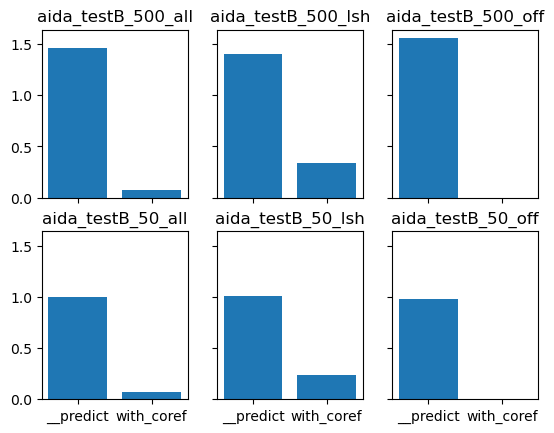

In [10]:
groups = df['src'].unique()
# groups = sorted(groups, key=lambda x: re.sub("_nocoref", "", x))
groups = sorted(groups)
n_cols = 3
n_rows = 2
idxs = [[x, y] for y in range(n_rows) for x in range(n_cols)]

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, sharey=True)

i = 0
for g in groups:
    dtemp = df.loc[df.src == g]
    col_idx = idxs[i][0]
    row_idx = idxs[i][1]
    x = dtemp['fn']
    y = dtemp['cumtime']
    axs[row_idx, col_idx].bar(x=x, height=y)
    axs[row_idx, col_idx].set_title(g)
    i += 1


# 2. MS Marco data

## 2.1. "Effectiveness": how much do predictions overlap?

- Run ED on the same file with detected mentions 
- Compare whether the linked entities are the same when using `with_coref` and when not using it
- Distinguish again between mentions that are coreferring and mentions that are not coreferring


In [11]:
files_msmarco = ['ed_coref_off', 'ed_coref_all', 'ed_coref_lsh']  #'ed_coref_lsh'
idx_cols = ["doc_id", "field", "start_pos", "end_pos"]

d_msmarco = {f: pd.read_parquet(f"{path_msmarco}predictions/{f}.parquet") for f in files_msmarco}

if d_msmarco["ed_coref_all"].shape[0] != d_msmarco["ed_coref_off"].shape[0]:
    warnings.warn("Not the same number of entities in the two datasets")

for df in d_msmarco.values():
    df.drop(columns=['md_score', 'ed_score'], inplace=True)
    df.set_index(idx_cols, inplace=True)

/tmp/ipykernel_252240/684049500.py:7: UserWarning: Not the same number of entities in the two datasets
  warnings.warn("Not the same number of entities in the two datasets")


### Differences in which entities are linked -- approximates comparison of recall. 

a ) all vs off


In [12]:
all_only = d_msmarco["ed_coref_all"][~d_msmarco["ed_coref_all"].index.isin(d_msmarco["ed_coref_off"].index)].shape[0]
reference_all_only = d_msmarco["ed_coref_all"].loc[d_msmarco["ed_coref_all"]["is_coref"] == 1].shape[0]

print(f"Percent of linked coreferring mentions in all that are not in off: {all_only/reference_all_only * 100}")

Percent of linked coreferring mentions in all that are not in off: 0.8095042172392511


b) all vs lsh


In [13]:
all_only = d_msmarco["ed_coref_all"][~d_msmarco["ed_coref_all"].index.isin(d_msmarco["ed_coref_lsh"].index)].shape[0]
reference_all_only = d_msmarco["ed_coref_all"].loc[d_msmarco["ed_coref_all"]["is_coref"] == 1].shape[0]

print(f"Percent of linked coreferring mentions in all that are not in off: {all_only/reference_all_only * 100}")

Percent of linked coreferring mentions in all that are not in off: 0.10080230405266406


### Differences in how entities are linked -- approximates comparison of precision

In [14]:
colnames_to_change = ["entity", "ed_score", "tag"]

for name, df in d_msmarco.items():
    cols = df.columns 
    new_colnames = [f"{x}_{name}" if x in colnames_to_change else x for x in cols]
    d_msmarco[name].columns = new_colnames


In [15]:

d_compare = (d_msmarco["ed_coref_all"]
                .join(d_msmarco["ed_coref_off"].drop(columns=["is_coref", "tag_ed_coref_off"]))
                .join(d_msmarco["ed_coref_lsh"].drop(columns=["is_coref", "tag_ed_coref_lsh"]))
                .reset_index()
            )

# display(d_compare.head())
d_compare['same_entity_off'] = np.where(d_compare["entity_ed_coref_all"] == d_compare["entity_ed_coref_off"], 1, 0)
d_compare['same_entity_lsh'] = np.where(d_compare["entity_ed_coref_all"] == d_compare["entity_ed_coref_lsh"], 1, 0)

assert d_compare.shape[0] == d_msmarco["ed_coref_all"].shape[0], "not the same number of entities in d_compare and ed_coref"

print("Summary statistics across all mentions and all documents:")
print("for option 'off':")
display(d_compare.groupby("is_coref")["same_entity_off"].describe())
print("for option 'lsh':")
display(d_compare.groupby("is_coref")["same_entity_lsh"].describe())

Summary statistics across all mentions and all documents:
for option 'off':


,count,mean,std,min,25%,50%,75%,max
is_coref,,,,,,,,
0,1440719.0,0.994016,0.077123,0.0,1.0,1.0,1.0,1.0
1,97220.0,0.380827,0.485593,0.0,0.0,0.0,1.0,1.0


for option 'lsh':


,count,mean,std,min,25%,50%,75%,max
is_coref,,,,,,,,
0,1440719.0,0.997687,0.048035,0.0,1.0,1.0,1.0,1.0
1,97220.0,0.793952,0.404468,0.0,1.0,1.0,1.0,1.0


In [16]:

plt_inputs = {
        "all": {
                "df": d_compare,
                "title": "All mentions",
                "filename": "msmarco_overlap_all"
                },
        "coref_only": {
                "df": d_compare.loc[d_compare['is_coref']==1, :],
                "title": "Coref. mentions", # coreferring mentions
                "filename": "msmarco_overlap_corefs"
                },
        "no_coref": {
                "df": d_compare.loc[d_compare['is_coref']==0, :],
                "title": "Non-coref. mentions", # non-coreferring mentions
                "filename": "msmarco_overlap_nocorefs"
        }
}

evaluation option off 
-----------------
Average overlap across documents (unweighted) for all: 0.935
Average overlap across documents (unweighted) for coref_only: 0.342
Average overlap across documents (unweighted) for no_coref: 0.99
evaluation option lsh 
-----------------
Average overlap across documents (unweighted) for all: 0.979
Average overlap across documents (unweighted) for coref_only: 0.793
Average overlap across documents (unweighted) for no_coref: 0.996


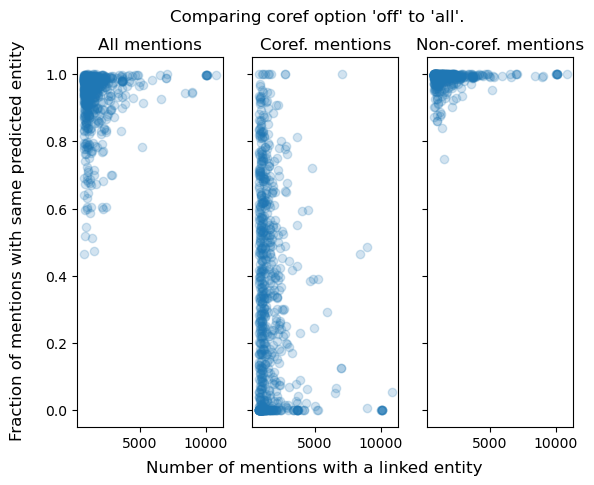

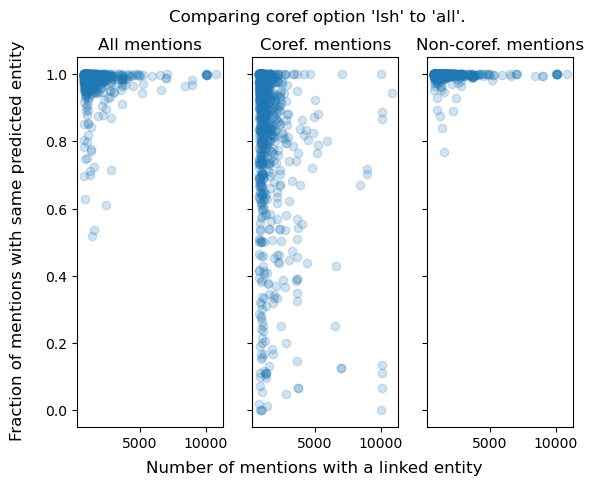

In [22]:
n_mentions_min = 5

d_size = d_compare.groupby(d_compare['doc_id']).size().to_frame('n_mentions')

for option in ["off", "lsh"]: # make plots for two options
    print(f"evaluation option {option} \n-----------------")
    dep_var = f"same_entity_{option}"

    d_coref = d_compare.loc[d_compare['is_coref'] == 1]
    d_size_corefs = d_coref.groupby(d_coref['doc_id']).size().to_frame('n_mentions').reset_index()
    d_size_corefs = d_size_corefs.loc[d_size_corefs['n_mentions'] > n_mentions_min]

    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)

    idx = 0 
    for sample, input in plt_inputs.items():
        df = input['df']
        # aggregate, join 
        d_agg = df.groupby(df['doc_id']).agg({dep_var: "mean"})
        d_agg = d_agg.join(d_size).reset_index()

        # keep only docs with sufficient number of coreferring mentions 
        d_agg = d_agg.loc[d_agg["doc_id"].isin(d_size_corefs['doc_id'])]

        print(f"Average overlap across documents (unweighted) for {sample}: {round(d_agg[dep_var].mean(), 3)}")
        
        # plot 
        # fig, ax = plt.subplots()
        ax[idx].scatter(x=d_agg['n_mentions'], y=d_agg[dep_var], alpha=0.2)
        ax[idx].set_title(input['title'])
        idx += 1


    fig.supxlabel(f"Number of mentions with a linked entity ")
    fig.supylabel(f"Fraction of mentions with same predicted entity")
    fig.suptitle(f"Comparing coref option '{option}' to 'all'.")
    fig.savefig(fname=f"figs/msmarco_overlap_{option}.pdf")

## 2.2. Time complexity

In [23]:
n_docs = 1000 ## To be finished 
files = os.listdir(f"{path_msmarco}/timing/")
# files = [f for f in files if str(n_docs) in f and "lsh" not in f]
files = [f for f in files if str(n_docs) in f]

timing_msmarco = {}

for f in files:
    with open(f"{path_msmarco}/timing/{f}", "rb") as file:
        key = re.sub(f"_ndocs_{n_docs}.pickle", "", f)
        timing_msmarco[key] = pickle.load(file)

for key, data in timing_msmarco.items():
    df = pd.DataFrame.from_dict(data, orient="index").reset_index(names="docid")
    timing_msmarco[key] = df

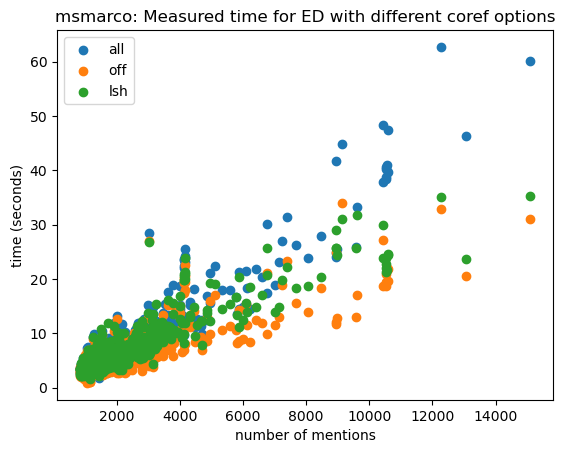

In [24]:
fig, ax = plt.subplots()

for lbl, d in timing_msmarco.items():
    x = d['n_mentions']
    y = d['timing_ed']
    lbl = re.sub(f".pickle|ed_coref_ndocs_{n_docs}_", "", lbl)
    ax.scatter(x=x, y=y, label=lbl)

ax.legend()
ax.set_xlabel("number of mentions")
ax.set_ylabel("time (seconds)")
ax.set_title("msmarco: Measured time for ED with different coref options")

fig.savefig(fname=f"figs/timing_msmarco.pdf")